In [2]:
import numpy as np, pandas as pd, tensorflow as tf
tf.random.set_seed(42)
np.random.seed(42)


In [3]:
df = pd.read_csv("water_potability.csv")
TARGET = "Potability"
X = df.drop(columns=[TARGET])
y = df[TARGET]


In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


In [5]:
numeric_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale",  StandardScaler())
])


In [6]:
preprocess = ColumnTransformer([
    ("num", numeric_pipeline, X.columns)   # every column is numeric
])


In [7]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.176,
    stratify=y_train_full, random_state=42)


In [8]:
from tensorflow.keras import layers, regularizers, models, optimizers, callbacks, metrics


In [9]:
def build_model(input_dim, dropout_rate=0.30, l2_factor=0.001):
    reg = regularizers.l2(l2_factor)
    inputs = layers.Input(shape=(input_dim,))

    # Hidden layer 1
    x = layers.Dense(64, activation="relu", kernel_regularizer=reg)(inputs)
    x = layers.Dropout(dropout_rate)(x)

    # Hidden layer 2
    x = layers.Dense(32, activation="relu", kernel_regularizer=reg)(x)
    x = layers.Dropout(dropout_rate)(x)

    # Output layer: 1 neuron, sigmoid → probability
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return models.Model(inputs, outputs)


In [10]:
model = build_model(input_dim=X.shape[1])
opt = optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-3)

In [11]:
model.compile(
    optimizer=opt,
    loss="binary_crossentropy",
    metrics=[
        metrics.BinaryAccuracy(name="acc"),
        metrics.Precision(name="prec"),
        metrics.Recall(name="rec")
    ]
)


In [12]:
es = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)


In [13]:
history = model.fit(
    preprocess.fit_transform(X_train), y_train,
    validation_data=(preprocess.transform(X_val), y_val),
    epochs=100,
    batch_size=32,
    callbacks=[es],
    verbose=2
)


Epoch 1/100
72/72 - 3s - 47ms/step - acc: 0.5606 - loss: 0.7519 - prec: 0.3825 - rec: 0.2056 - val_acc: 0.6041 - val_loss: 0.7189 - val_prec: 0.4211 - val_rec: 0.0419
Epoch 2/100
72/72 - 0s - 4ms/step - acc: 0.5981 - loss: 0.7244 - prec: 0.4494 - rec: 0.1341 - val_acc: 0.6224 - val_loss: 0.7070 - val_prec: 0.7500 - val_rec: 0.0471
Epoch 3/100
72/72 - 0s - 4ms/step - acc: 0.6068 - loss: 0.7123 - prec: 0.4870 - rec: 0.1464 - val_acc: 0.6367 - val_loss: 0.6959 - val_prec: 0.8095 - val_rec: 0.0890
Epoch 4/100
72/72 - 1s - 9ms/step - acc: 0.6242 - loss: 0.6943 - prec: 0.5632 - rec: 0.1642 - val_acc: 0.6449 - val_loss: 0.6856 - val_prec: 0.8400 - val_rec: 0.1099
Epoch 5/100
72/72 - 0s - 4ms/step - acc: 0.6282 - loss: 0.6918 - prec: 0.5729 - rec: 0.1844 - val_acc: 0.6592 - val_loss: 0.6778 - val_prec: 0.8333 - val_rec: 0.1571
Epoch 6/100
72/72 - 1s - 9ms/step - acc: 0.6408 - loss: 0.6812 - prec: 0.6120 - rec: 0.2168 - val_acc: 0.6776 - val_loss: 0.6687 - val_prec: 0.8000 - val_rec: 0.2304
Epo

In [15]:
X_test_pp = preprocess.transform(X_test)
y_pred_proba = model.predict(X_test_pp).ravel()
y_pred = (y_pred_proba > 0.5).astype(int)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [16]:
from sklearn.metrics import classification_report, f1_score

print(classification_report(y_test, y_pred, digits=4))


              precision    recall  f1-score   support

           0     0.6875    0.8800    0.7719       300
           1     0.6667    0.3750    0.4800       192

    accuracy                         0.6829       492
   macro avg     0.6771    0.6275    0.6260       492
weighted avg     0.6794    0.6829    0.6580       492



In [17]:
f1  = f1_score(y_test, y_pred)
acc = (y_pred == y_test).mean()
print(f"Accuracy = {acc:.3f}  F1 = {f1:.3f}")


Accuracy = 0.683  F1 = 0.480


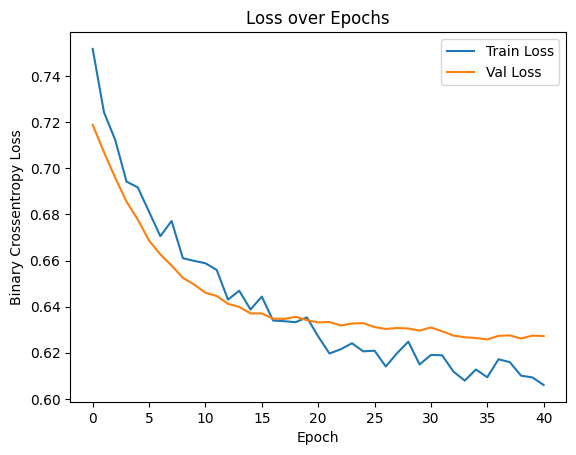

In [18]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Binary Crossentropy Loss")
plt.show()
